<a href="https://colab.research.google.com/github/LenaVolzhina/playing-with-neural-networks/blob/master/DL_chapter_5_basic_convolutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5.2. Свертки и сверточные сети

In [0]:
import tensorflow as tf
import numpy as np

Заглушки для входных данных

In [0]:
x_inp = tf.placeholder(tf.float32, [5, 5])
w_inp = tf.placeholder(tf.float32, [3, 3])

В TensorFlow двумерные свертки реализуются с помощью функции conv2d,
которая принимает на вход тензор сверточных весов и тензор карт признаков набора изображений. 

Дело в том, что входные данные для
двумерной свертки в TensorFlow должны иметь четырехмерную структуру, которая выглядит так:


`[размер батча, высота, ширина, каналы]`.


А размерность тензора сверточных весов определяется размерами ядра свертки
и числом каналов как на входе, так и на выходе; получается снова четырехмерный
тензор, который на этот раз нужно интерпретировать следующим образом:

`[высота, ширина, входные каналы, выходные каналы]`.

**`padding`** -- как быть с окнами, которые "вылезают" за границы исходного массива
* VALID -- уменьшает размер выходного массива относительно входного
* SAME -- размер остается прежним, края добиваются нолями

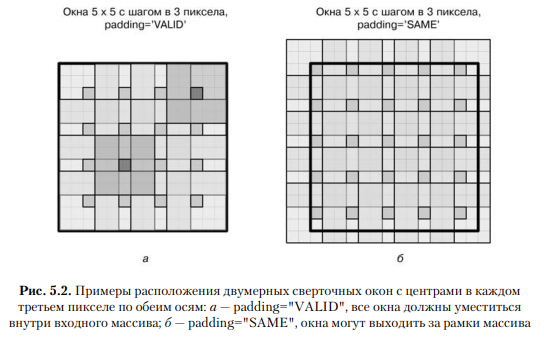

**`strides`** -- шаг для окон по  размерностям тензора
* первая компонента -- примеры в мини-батче
* вторая и третья -- шаг по сетке изображения (на картинке выше шаг 3)
* четвертая -- каналы / карты признаков

In [0]:
x = tf.reshape(x_inp, [1, 5, 5, 1])
w = tf.reshape(w_inp, [3, 3, 1, 1])

In [0]:
x_valid = tf.nn.conv2d(x, w, strides=[1, 1, 1, 1], padding="VALID")
x_same = tf.nn.conv2d(x, w, strides=[1, 1, 1, 1], padding="SAME")

x_valid_half = tf.nn.conv2d(x, w, strides=[1, 2, 2, 1], padding="VALID")
x_same_half = tf.nn.conv2d(x, w, strides=[1, 2, 2, 1], padding="SAME")

Задаём конкретные данные

In [0]:
x = np.array([
  [0, 1, 2, 1, 0],
  [4, 1, 0, 1, 0],
  [2, 0, 1, 1, 1],
  [1, 2, 3, 1, 0],
  [0, 4, 3, 2, 0]
])
w = np.array([
  [0, 1, 0],
  [1, 0, 1],
  [2, 1, 0]
])

In [0]:
sess = tf.Session()
y_valid, y_same, y_valid_half, y_same_half = sess.run(
  [x_valid, x_same, x_valid_half, x_same_half],
  feed_dict={x_inp: x, w_inp: w}
)

In [0]:
print("padding=VALID:\n", y_valid[0, :, :, 0])
print("padding=SAME:\n", y_same[0, :, :, 0])
print("padding=VALID, stride 2:\n", y_valid_half[0, :, :, 0])
print("padding=SAME, stride 2:\n", y_same_half[0, :, :, 0])

padding=VALID:
 [[ 9.  5.  4.]
 [ 8.  8. 10.]
 [ 8. 15. 12.]]
padding=SAME:
 [[ 5. 11.  4.  3.  3.]
 [ 3.  9.  5.  4.  4.]
 [ 5.  8.  8. 10.  3.]
 [ 4.  8. 15. 12.  6.]
 [ 5.  5.  9.  4.  2.]]
padding=VALID, stride 2:
 [[ 9.  4.]
 [ 8. 12.]]
padding=SAME, stride 2:
 [[5. 4. 3.]
 [5. 8. 3.]
 [5. 9. 2.]]


**Субдискретизация** -- обобщаем информацию до наличия признаков, забывая об их местоположении

Смысл субдискретизации прост: в сверточных сетях обычно исходят из предположения, что наличие или отсутствие того или иного признака гораздо важнее, чем его точные координаты. Поэтому можно позволить себе «обобщить» выделяемые признаки, потеряв часть информации об их
местоположении, но зато сократив размерность.

Для этого можно например брать максимум из всей группы (`max-pooling`)

Обычно разбивают на непересекающиеся окна с фиксированным шагом и из каждого берут максимум

In [0]:
x_inp = tf.placeholder(tf.float32, [4, 4])
x = tf.reshape(x_inp, [1, 4, 4, 1])

In [0]:
x_valid = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding="VALID")
x_valid_half = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")

In [0]:
x = np.array([
  [0, 1, 2, 1],
  [4, 1, 0, 1],
  [2, 0, 1, 1],
  [1, 2, 3, 1]
])
y_valid, y_valid_half = sess.run(
  [x_valid, x_valid_half],
  feed_dict={x_inp: x}
)
print("padding=VALID:\n", y_valid[0, :, :, 0])
print("padding=VALID, stride 2:\n", y_valid_half[0, :, :, 0])

padding=VALID:
 [[4. 2. 2.]
 [4. 1. 1.]
 [2. 3. 3.]]
padding=VALID, stride 2:
 [[4. 2.]
 [2. 3.]]


# 5.3. Свертки для распознавания цифр

## NB! Необходимо переключить runtime на GPU

In [0]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [0]:
x = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, 10])

Делаем двумерный массив, чтобы была информация о местоположении

-1 -- заранее неизвестный размер мини-батча

1 -- grayscale картинка, только один канал

In [0]:
x_image = tf.reshape(x, [-1,28,28,1])

Сделаем свертку с ядром 5х5 с 32 фильтрами (как следствие, 32 выходными картами признаков)

Инициализируем truncated_normal -- потому что будем использовать ReLU

Сдвиги -- по одному на свертку, независимо от места её применения

In [0]:
# описываем свёртку
W_conv_1 = tf.Variable(tf.truncated_normal([5, 5, 1, 32], stddev=0.1))
b_conv_1 = tf.Variable(tf.constant(0.1, shape=[32]))

In [0]:
# создаём слой
conv_1 = tf.nn.conv2d(
  x_image, W_conv_1, 
  strides=[1, 1, 1, 1], padding="SAME"
) + b_conv_1

In [0]:
# нелинейность aka функция активации -- ReLU
h_conv_1 = tf.nn.relu(conv_1)

In [0]:
# субдискретизация
h_pool_1 = tf.nn.max_pool(
  h_conv_1, ksize=[1, 2, 2, 1], 
  strides=[1, 2, 2, 1], padding="SAME"
)

Бахнем сразу второй слой, уже с 64 фильтрами

In [0]:
W_conv_2 = tf.Variable(tf.truncated_normal([5, 5, 32, 64], stddev=0.1))
b_conv_2 = tf.Variable(tf.constant(0.1, shape=[64]))

conv_2 = tf.nn.conv2d(
  h_pool_1, W_conv_2, 
  strides=[1, 1, 1, 1], padding="SAME"
) + b_conv_2

h_conv_2 = tf.nn.relu(conv_2)

h_pool_2 = tf.nn.max_pool(
  h_conv_2, ksize=[1, 2, 2, 1], 
  strides=[1, 2, 2, 1], padding="SAME"
)

Получается, 
* из исходной картинки 28х28х1 получили
* после первого слоя и пулинга 14х14х32, 
* после второго слоя и пулинга 7х7х64

In [0]:
h_pool_2_flat = tf.reshape(h_pool_2, [-1, 7*7*64])

Теперь полносвязные слои.

В первом 1024 нейрона (?!) и ReLU, регуляризация дропаутом

In [0]:
W_fc_1 = tf.Variable(tf.truncated_normal([7*7*64, 1024], stddev=0.1))
b_fc_1 = tf.Variable(tf.constant(0.1, shape=[1024]))
h_fc_1 = tf.nn.relu(tf.matmul(h_pool_2_flat, W_fc_1) + b_fc_1)

In [0]:
keep_probability = tf.placeholder(tf.float32)
h_fc_1_drop = tf.nn.dropout(h_fc_1, keep_probability)

Выходной слой с 10 выходами и softmax поверх них

In [0]:
W_fc_2 = tf.Variable(tf.truncated_normal([1024, 10], stddev=0.1))
b_fc_2 = tf.Variable(tf.constant(0.1, shape=[10]))

logit_conv = tf.matmul(h_fc_1_drop, W_fc_2) + b_fc_2
y_conv = tf.nn.softmax(logit_conv)

Функция ошибки и оптимизатор (Адам)

In [0]:
cross_entropy = tf.reduce_mean(
  tf.nn.softmax_cross_entropy_with_logits(logits=logit_conv, labels=y)
)
train_step = tf.train.AdamOptimizer(0.0001).minimize(cross_entropy)

In [0]:
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [0]:
from datetime import datetime

In [0]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

for i in range(10000):
  batch_xs, batch_ys = mnist.train.next_batch(64)
  sess.run(
    train_step,
    feed_dict={x: batch_xs, y: batch_ys, keep_probability: 0.5}
  )
  if i % 500 == 0:
    print(f"[{datetime.now()}] Epoch {i}")

print(sess.run(
  accuracy,
  feed_dict={x: mnist.test.images, y: mnist.test.labels, keep_probability: 1.}
))

[2019-11-29 14:54:19.155566] Epoch 0
[2019-11-29 14:54:23.374943] Epoch 500
[2019-11-29 14:54:27.540763] Epoch 1000
[2019-11-29 14:54:31.659407] Epoch 1500
[2019-11-29 14:54:35.814416] Epoch 2000
[2019-11-29 14:54:39.905079] Epoch 2500
[2019-11-29 14:54:44.079480] Epoch 3000
[2019-11-29 14:54:48.239807] Epoch 3500
[2019-11-29 14:54:52.355991] Epoch 4000
[2019-11-29 14:54:56.524336] Epoch 4500
[2019-11-29 14:55:00.646608] Epoch 5000
[2019-11-29 14:55:04.808890] Epoch 5500
[2019-11-29 14:55:08.915609] Epoch 6000
[2019-11-29 14:55:13.083771] Epoch 6500
[2019-11-29 14:55:17.244196] Epoch 7000
[2019-11-29 14:55:21.362911] Epoch 7500
[2019-11-29 14:55:25.551209] Epoch 8000
[2019-11-29 14:55:29.674460] Epoch 8500
[2019-11-29 14:55:33.974458] Epoch 9000
[2019-11-29 14:55:38.252722] Epoch 9500
0.9904


# То же самое на Keras

In [0]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils

Using TensorFlow backend.


In [0]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


Готовим данные

In [0]:
# sizes, reshaping
batch_size, img_rows, img_cols = 64, 28, 28
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

In [0]:
# (0, 255) -> (0, 1)   (not neccessary)
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
X_train /= 255
X_test /= 255

In [0]:
# one-hot encoding of labels
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

Сверточные слои

In [0]:
# describe model
model = Sequential()

# first argument -- # of output feature maps
# second & third -- kernel size
# input_shape -- shape of input (oh, really?)
# border_mode ~ padding

model.add(Convolution2D(32, 5, 5, border_mode="same", input_shape=input_shape))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), border_mode="same"))

model.add(Convolution2D(64, 5, 5, border_mode="same", input_shape=input_shape))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), border_mode="same"))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), input_shape=(28, 28, 1..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same")`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), input_shape=(28, 28, 1..., padding="same")`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same")`
  


Удобно, что Keras сам создаёт матрицы весов и сдвигов нужных размерностей

Полносвязные слои

In [0]:
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(Dropout(0.5))

model.add(Dense(10))
model.add(Activation("softmax"))

Компилируем и обучаем

In [0]:
model.compile(
  loss="categorical_crossentropy",
  optimizer="adam", metrics=["accuracy"]
)
model.fit(
  X_train, Y_train, batch_size=batch_size, nb_epoch=10,
  verbose=1, validation_data=(X_test, Y_test)
)

score = model.evaluate(X_test, Y_test, verbose=0)
print("Test score: %f" % score[0])
print("Test accuracy: %f" % score[1])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys




Train on 60000 samples, validate on 10000 samples
Epoch 1/10





60000/60000 [==============================] - 14s 233us/step - loss: 0.1288 - acc: 0.9603 - val_loss: 0.0491 - val_acc: 0.9842
Epoch 2/10
60000/60000 [==============================] - 13s 211us/step - loss: 0.0429 - acc: 0.9867 - val_loss: 0.0311 - val_acc: 0.9896
Epoch 3/10
60000/60000 [==============================] - 13s 212us/step - loss: 0.0304 - acc: 0.9907 - val_loss: 0.0194 - val_acc: 0.9926
Epoch 4/10
60000/60000 [==============================] - 13s 215us/step - loss: 0.0232 - acc: 0.9924 - val_loss: 0.0217 - val_acc: 0.9929
Epoch 5/10
60000/60000 [==============================] - 13s 211us/step - loss: 0.0193 - acc: 0.9940 - val_loss: 0.0222 - val_acc: 0.9918
Epoch 6/10
60000/60000 [==============================] - 13s 212us/step - loss: 0.0148 - acc: 0.9954 - val_loss: 0.0322 - val_acc: 0.9905
Epoch 7/10
60000/60000 [==============================] - 13s 210us/step - loss: 0.0139 - acc: 0.9954 - val_l

### Про раннюю остановку (early stopping)

Качество на validate могло быть оптимальным на какой-нибудь промежуточной эпохе. Хорошо было бы тогдашнюю модель и вернуть

In [0]:
model.fit(
  X_train, Y_train,
  callbacks=[ModelCheckpoint(
    "model.hdf5", monitor="val_acc",
    save_best_only=True, save_weights_only=False, mode="auto"
  )],
  validation_split=0.1, nb_epoch=10, batch_size=64
)

Идея:
* поэкспериментировать со сдвинутым MNIST. там сверткам должно быть намнооого лучше, чем полносвязной сети